In [48]:
import wandb
import numpy as np
import sys
import torch
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import torch.nn as nn
import glob
import xarray as xr
import matplotlib.pyplot as plt


BASE = '/scratch/ab10313/pleiades/'
PATH_NN= BASE+'NN_data_smooth/'
save_path=BASE+"trained_models"


import submeso_ml.systems.regression_system as regression_system
import submeso_ml.models.fcnn as fcnn
import submeso_ml.data.dataset as dataset



In [49]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Not Available


In [50]:
#locations
location_index = np.zeros(846*12)
location_month_index= np.zeros(846*12)


for i in range(12):
    for j in range(846):
        location_index[i*846+j] = i
        location_month_index[i*846+j] = np.floor(j/60)


In [51]:
PATH_LIST_full = glob.glob(BASE+'*_smooth/preprcossed_data/')

In [52]:
PATH_LIST_full

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/08_kuroshio_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/06_california_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [53]:
label_list = ['Arabian Sea','Agulhas Current', 'New Zealand', 'Kuroshio Current', 'North Pacific', 'Equatorial Atlantic',
              'Gulf Stream', 'South Atlantic', 'Malvinas Current', 'South Pacific', 'California Current','Indian Ocean' ]

# prediction and target by location

## Resolution R^2

In [14]:
r2_summer_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_summer_loc.npy')
r2_winter_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_winter_loc.npy')
r2_m_loc_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_m_loc_loc.npy')
r2_cnn_loc = np.load('/scratch/ab10313/pleiades/trained_models/r2_cnn_loc.npy')

In [15]:
# sort by latitude

lat_rad = np.empty(12)
PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/lat.nc')
i_lat_path = 0

for i_lat in range(12):
    #if i_lat == 1 or i_lat ==10 or i_lat ==11:
    #    lat_rad[i_lat] = np.NaN
    #else:
    #    print(i_lat_path)
        lat_rad[i_lat] = xr.open_dataarray(PATH_LIST[i_lat]).values.mean()
    #    i_lat_path = i_lat_path+1
    
    
lat_rad_sorted = np.sort(lat_rad)[::-1]
lat_ind_sorted = np.argsort(lat_rad)[::-1]


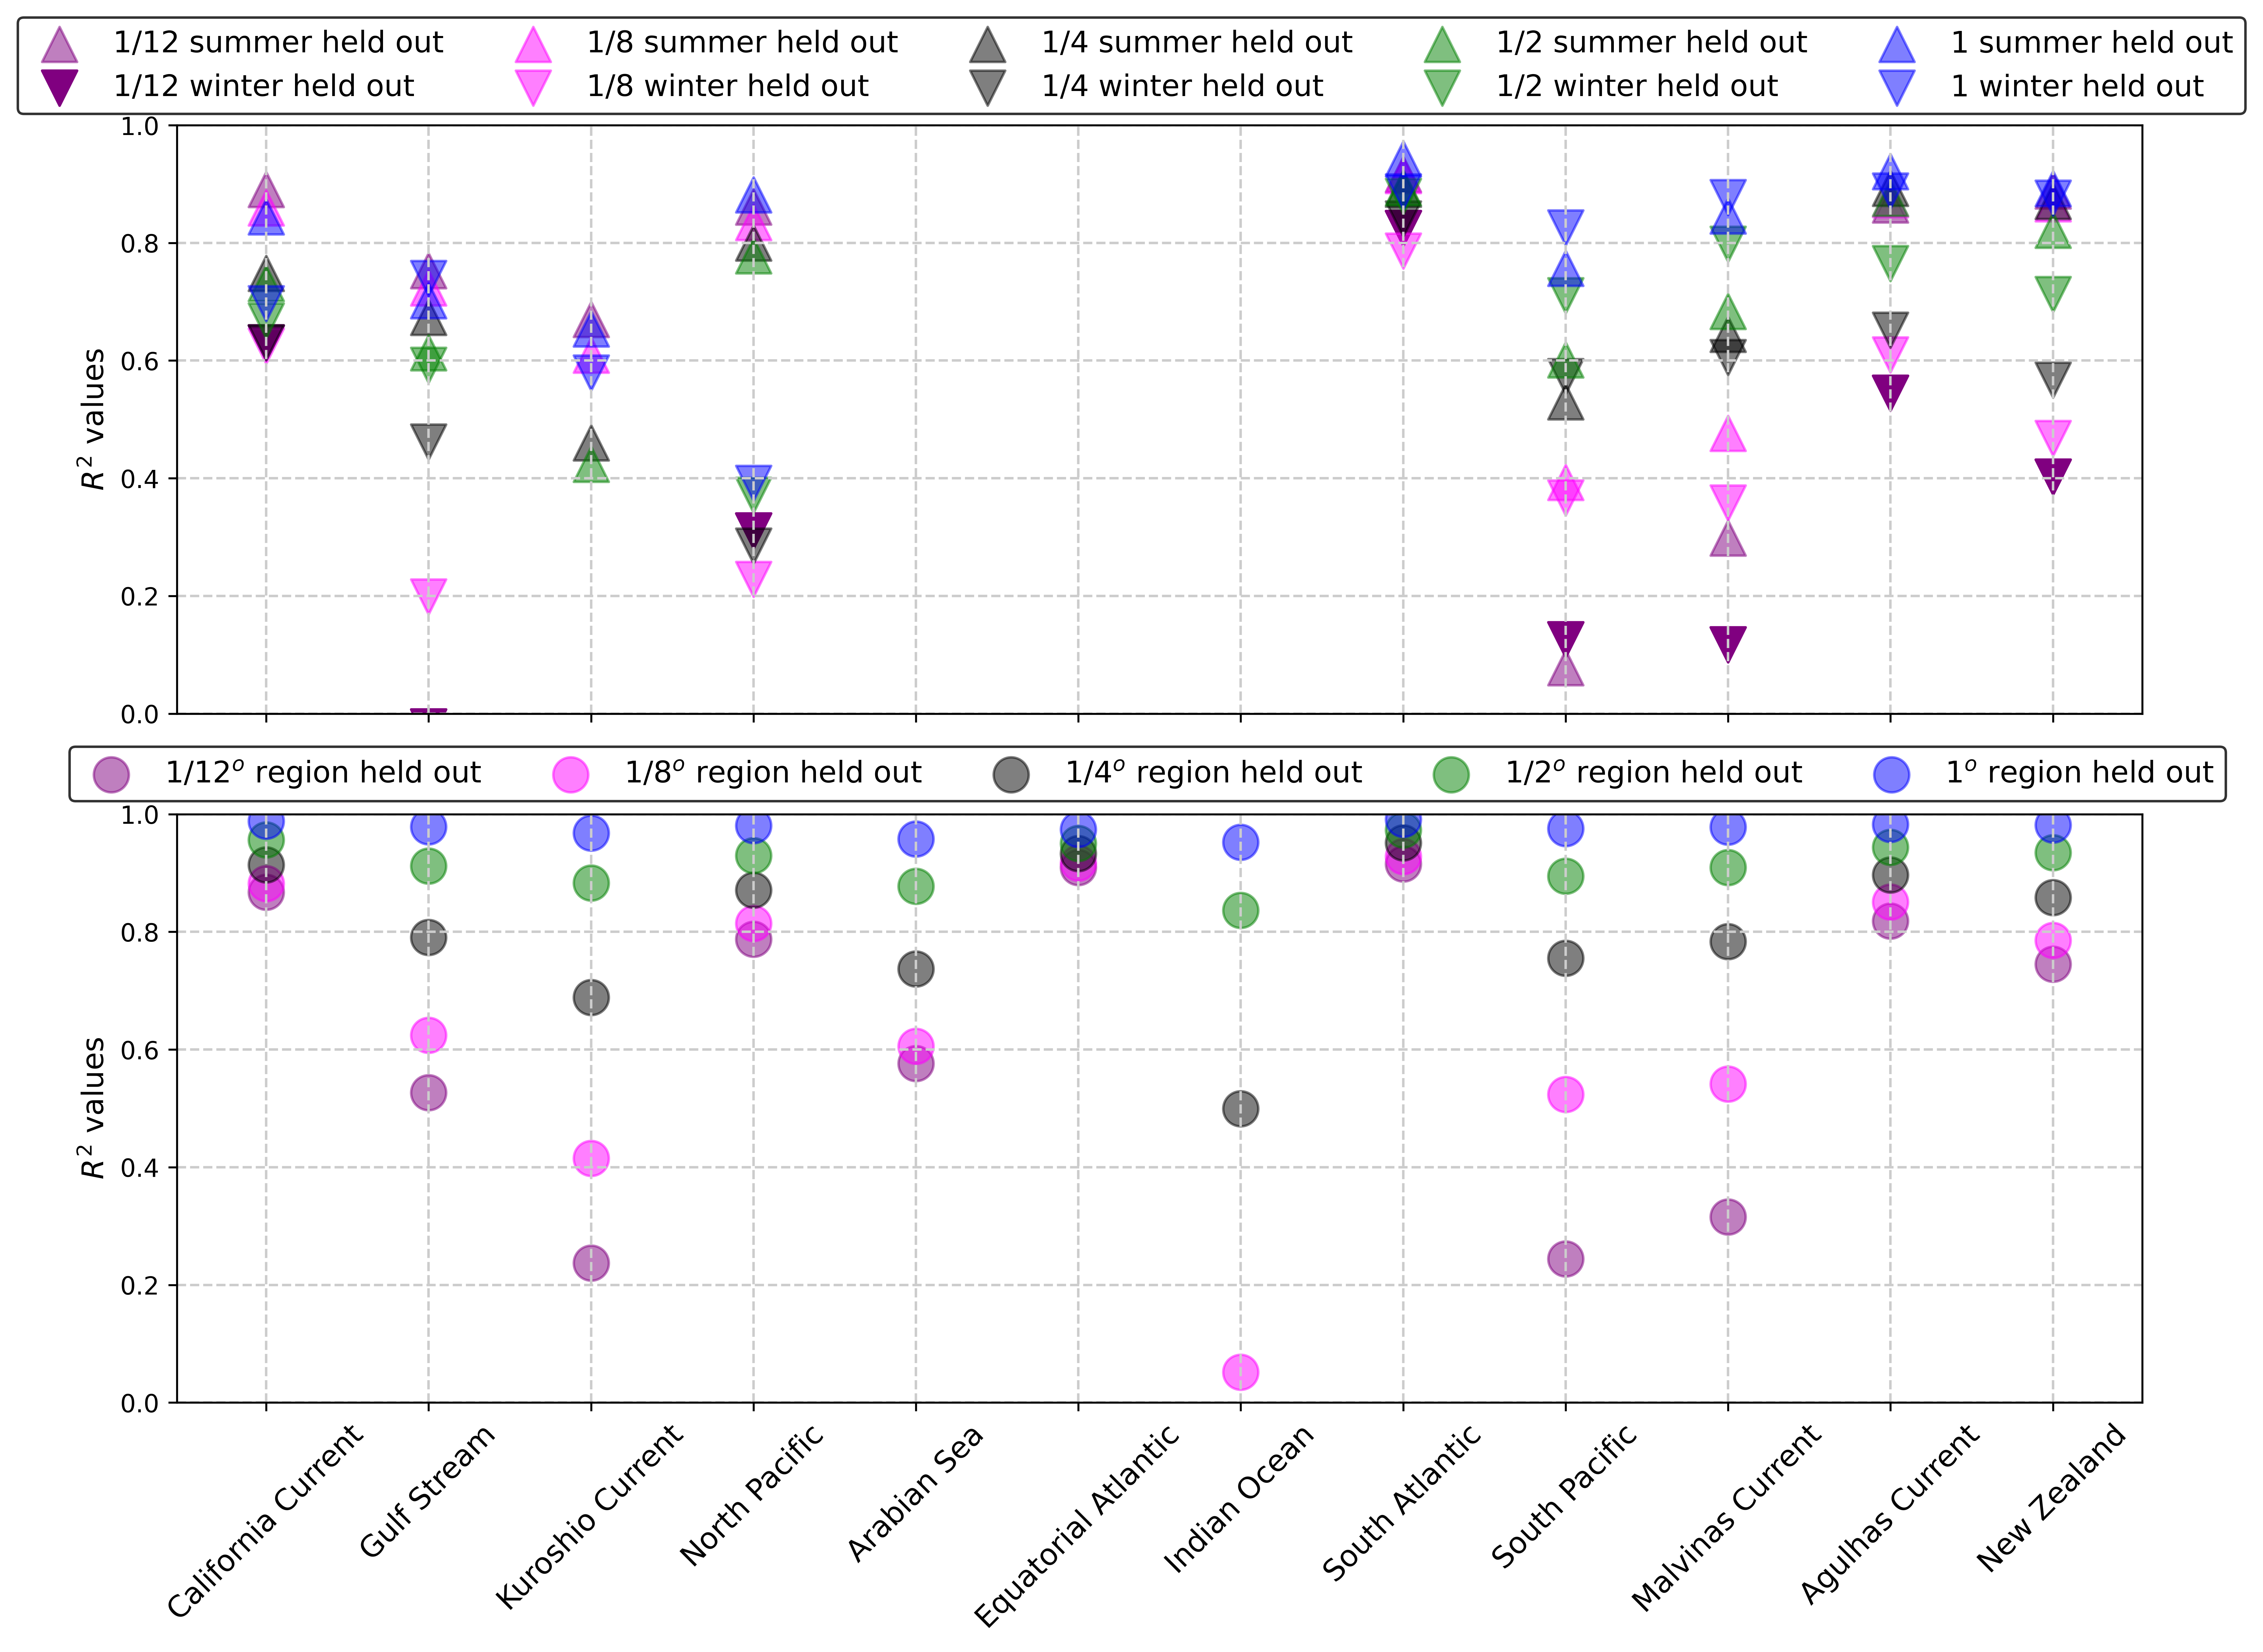

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,8),dpi=600)
fig.tight_layout(pad=2.0)


plt.subplot(2,1,1)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

plt.scatter(range(12),r2_summer_loc[0,lat_ind_sorted],s=200,marker='^',color= 'purple', alpha=0.5,label='1/12 summer held out')
plt.scatter(range(12),r2_winter_loc[0,lat_ind_sorted],s=200,marker='v',color= 'purple', label='1/12 winter held out')
#plt.scatter(range(12),r2_cnn_loc[0,lat_ind_sorted],s=200,c= 'purple',marker='*',alpha=0.5,label='$1/12^o$ CNN')

plt.scatter(range(12),r2_summer_loc[1,lat_ind_sorted],s=200,marker='^',color='magenta',alpha=0.5,label='1/8 summer held out')
plt.scatter(range(12),r2_winter_loc[1,lat_ind_sorted],s=200,marker='v',color='magenta',alpha=0.5,label='1/8 winter held out')
#plt.scatter(range(12),r2_cnn_loc[1,lat_ind_sorted],s=200,c= 'magenta',marker='*',alpha=0.5,label='$1/8^o$ CNN')

plt.scatter(range(12),r2_summer_loc[2,lat_ind_sorted],s=200,marker='^',color='k',alpha=0.5,label='1/4 summer held out')
plt.scatter(range(12),r2_winter_loc[2,lat_ind_sorted],s=200,marker='v',color='k',alpha=0.5,label='1/4 winter held out')
#plt.scatter(range(12),r2_cnn_loc[2,lat_ind_sorted],s=200,c= 'k',marker='*',alpha=0.5,label='$1/4^o$ CNN')

plt.scatter(range(12),r2_summer_loc[3,lat_ind_sorted],s=200,marker='^',color='green',alpha=0.5,label='1/2 summer held out')
plt.scatter(range(12),r2_winter_loc[3,lat_ind_sorted],s=200,marker='v',color='green',alpha=0.5,label='1/2 winter held out')
#plt.scatter(range(12),r2_cnn_loc[3,lat_ind_sorted],s=200,c= 'green',marker='*',alpha=0.5,label='$1/2^o$ CNN')

plt.scatter(range(12),r2_summer_loc[4,lat_ind_sorted],s=200,marker='^',color='blue',alpha=0.5,label='1 summer held out')
plt.scatter(range(12),r2_winter_loc[4,lat_ind_sorted],s=200,marker='v',color='blue',alpha=0.5,label='1 winter held out')
#plt.scatter(range(12),r2_cnn_loc[4,lat_ind_sorted],s=200,c= 'blue',marker='*',alpha=0.5,label='$1^o$ CNN')

#my_xticks = [label_list[i] for i in lat_ind_sorted] 
#plt.xticks([]);
plt.xticks(np.arange(len(label_list)), [],rotation = 45, fontsize=12);
plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=12,bbox_to_anchor=(1.06, 1.208),ncol=5).get_frame().set_edgecolor('k')

plt.subplot(2,1,2)
plt.grid(color=[0.8,0.8,0.8], linestyle='--', linewidth=1,)

#plt.scatter(range(12),r2_m_loc_loc[0,lat_ind_sorted],s=200,marker='o',color= 'purple',alpha=0.5, label='1/12 m region')
plt.scatter(range(12),r2_cnn_loc[0,lat_ind_sorted],s=200,c= 'purple',marker='o',alpha=0.5,label='$1/12^o$ region held out')

#plt.scatter(range(12),r2_m_loc_loc[1,lat_ind_sorted],s=200,marker='o',color='magenta',alpha=0.5,label='1/8 m region')
plt.scatter(range(12),r2_cnn_loc[1,lat_ind_sorted],s=200,c= 'magenta',marker='o',alpha=0.5,label='$1/8^o$ region held out')

#plt.scatter(range(12),r2_m_loc_loc[2,lat_ind_sorted],s=200,marker='o',color='k',alpha=0.5,label='1/4 m region')
plt.scatter(range(12),r2_cnn_loc[2,lat_ind_sorted],s=200,c= 'k',marker='o',alpha=0.5,label='$1/4^o$ region held out')

#plt.scatter(range(12),r2_m_loc_loc[3,lat_ind_sorted],s=200,marker='o',color='green',alpha=0.5,label='1/2 m region')
plt.scatter(range(12),r2_cnn_loc[3,lat_ind_sorted],s=200,c= 'green',marker='o',alpha=0.5,label='$1/2^o$ region held out')

#plt.scatter(range(12),r2_m_loc_loc[4,lat_ind_sorted],s=200,marker='o',color='blue',alpha=0.5,label='1 m region')
plt.scatter(range(12),r2_cnn_loc[4,lat_ind_sorted],s=200,c= 'blue',marker='o',alpha=0.5,label='$1^o$ region held out')


my_xticks = [label_list[i] for i in lat_ind_sorted] 
plt.xticks(np.arange(len(label_list)), my_xticks,rotation = 45,fontsize=12);
#plt.xticks(np.arange(len(label_list)), label_list,rotation = 45, fontsize=12);
plt.ylabel('$R^2$ values', fontsize=12)
plt.ylim([0,1])
plt.legend(fontsize=12,bbox_to_anchor=(1.05, 1.14),ncol=5).get_frame().set_edgecolor('k')
plt.savefig('./figures/r2_sensitivity_global_norm',bbox_inches = 'tight')
